In [1]:
!nvidia-smi

Sun May 12 16:15:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   25C    P8             16W /  230W |       0MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import math
from tqdm.auto import tqdm
from datasets import load_dataset, concatenate_datasets
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

In [3]:
class NoiseScheduler(nn.Module):
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        assert beta_start < beta_end < 1.0, "beta1 and beta2 must be in (0, 1)"

        beta = ((beta_end - beta_start) * torch.arange(0, num_timesteps + 1, dtype=torch.float32) / num_timesteps + beta_start).to(device)
        sqrt_beta = torch.sqrt(beta)
        alpha = 1. - beta
        log_alpha = torch.log(alpha)
        alpha_hat = torch.cumsum(log_alpha, dim=0).exp()
        
        one_over_sqrt_alpha = 1 / torch.sqrt(alpha)
        sqrt_alpha_hat = torch.sqrt(alpha_hat)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat)

        self.register_buffer("beta", beta)
        self.register_buffer("sqrt_beta", sqrt_beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_hat", alpha_hat)
        self.register_buffer("one_over_sqrt_alpha", one_over_sqrt_alpha)
        self.register_buffer("sqrt_alpha_hat", sqrt_alpha_hat)
        self.register_buffer("sqrt_one_minus_alpha_hat", sqrt_one_minus_alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,))

    def denoise(self, noisy_image, predicted_noise, z, t):
        one_over_sqrt_alpha = self.one_over_sqrt_alpha[t]
        pred_noise_coeff = (1 - self.alpha[t])/self.sqrt_one_minus_alpha_hat[t]
        sqrt_beta = self.sqrt_beta[t]
        return (
                one_over_sqrt_alpha * (noisy_image - (pred_noise_coeff * predicted_noise))
                + sqrt_beta * z
            )

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x):
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
           
            if self.in_channels == self.out_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualBlock(out_channels, out_channels),
            ResidualBlock(out_channels, out_channels),
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.conv(x)
        return x

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ClassEmbedding(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes=2, num_features=64):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_features = num_features

        self.init_conv = ResidualBlock(in_channels, num_features, is_res=True)

        self.down_conv1 = DownBlock(num_features, num_features)
        self.down_conv2 = DownBlock(num_features, 2 * num_features)

        self.mid_block = nn.Sequential(
            nn.AvgPool2d(7), 
            nn.GELU()
        )

        self.time_embedding1 = SinusoidalPositionEmbeddings(2 * num_features)
        self.time_embedding2 = SinusoidalPositionEmbeddings(num_features)

        self.class_embedding1 = ClassEmbedding(num_classes, 2 * num_features)
        self.class_embedding2 = ClassEmbedding(num_classes, num_features)
        

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(2 * num_features, 2 * num_features, kernel_size=16, stride=8, padding=4),
            nn.GroupNorm(8, 2 * num_features),
            nn.ReLU(),
        )
    
        self.up_conv1 = UpBlock(4 * num_features, num_features)
        self.up_conv2 = UpBlock(2 * num_features, num_features)
        self.out_conv = nn.Sequential(
            nn.Conv2d(2 * num_features, num_features, 3, 1, 1),
            nn.GroupNorm(8, num_features),
            nn.ReLU(),
            nn.Conv2d(num_features, self.in_channels, 3, 1, 1)
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1_out = self.down_conv1(x)
        down2_out = self.down_conv2(down1_out)
        mid_out = self.mid_block(down2_out)
        c = nn.functional.one_hot(c, num_classes=self.num_classes).type(torch.float)
        
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.num_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        class_emb1 = self.class_embedding1(c).view(-1, self.num_features * 2, 1, 1)
        time_emb1 = self.time_embedding1(t).view(-1, self.num_features * 2, 1, 1)
        class_emb2 = self.class_embedding2(c).view(-1, self.num_features, 1, 1)
        time_emb2 = self.time_embedding2(t).view(-1, self.num_features, 1, 1)
        
        upsample_out = self.upsample(mid_out)

        up2_out = self.up_conv1(class_emb1 * upsample_out + time_emb1, down2_out)  
        up3_out = self.up_conv2(class_emb2 * up2_out + time_emb2, down1_out)
        out = self.out_conv(torch.cat((up3_out, x), 1))
        return out


In [75]:
batch = next(iter(train_dataloader))
labels = batch["labels"]
labels

tensor([1, 0, 0, 1, 0, 0, 1, 1])

In [76]:
context_mask = torch.bernoulli(torch.zeros_like(labels) + 0.5)
context_mask, labels

(tensor([0., 0., 0., 0., 1., 1., 0., 0.]), tensor([1, 0, 0, 1, 0, 0, 1, 1]))

In [77]:

context_mask = context_mask[:, None]
context_mask = context_mask.repeat(1,2)
context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
c = c * context_mask

In [89]:
labels.shape

torch.Size([8])

In [79]:
_emb = ClassEmbedding(2, 2 * 64)

In [88]:
class_emb1 = _emb(labels.float()).view(-1, 64 * 2, 1, 1)
class_emb1.shape

torch.Size([4, 128, 1, 1])

In [6]:
class Diffuser(nn.Module):
    def __init__(
        self,
        unet,
        noise_scheduler,
        num_timesteps,
        num_classes,
        eta=0.,
        drop_prob=0.1
    ):
        super().__init__()
        self.unet = unet
        self.num_timesteps = num_timesteps
        self.num_classes = num_classes
        self.criterion = nn.MSELoss()
        self.eta = eta
        self.noise_scheduler = noise_scheduler
        self.drop_prob = drop_prob

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))
    
    def forward(self, x, labels=None):
        timesteps = torch.randint(1, self.num_timesteps + 1, (x.shape[0],)).to(x.device)
        noisy_x, noise = self.noise_scheduler.noise_images(x, timesteps)
        context_mask = torch.bernoulli(torch.zeros_like(labels) + self.drop_prob).to(x.device)
        predicted_noise = self.unet(noisy_x, labels, timesteps / self.num_timesteps, context_mask)
        return self.criterion(noise, predicted_noise)
   
    def sample(self, n_samples, size, device):
        x = torch.randn(n_samples, *size).to(device)
        
        for t in tqdm(range(self.num_timesteps, 0, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
            predicted_noise = self.unet(x, t / self.num_timesteps)
            x = self.noise_scheduler.denoise(x, predicted_noise, z, t-1)
        return x

    def sample_v3(self, n_samples, size, device, guidance_scale = 0.0):
        x_i = torch.randn(n_samples, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i= torch.arange(0, self.num_classes).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_samples/c_i.shape[0]))
        context_mask = torch.zeros_like(c_i).to(device)
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_samples:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        for i in tqdm(range(self.num_timesteps, 0, -1), desc="Sampling"):
            t = torch.tensor([i / self.num_timesteps]).to(device)
            t = t.repeat(n_samples,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t = t.repeat(2,1,1,1)

            z = torch.randn(n_samples, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            predicted_noise = self.unet(x_i, c_i, t, context_mask)
            predicted_noise1 = predicted_noise[:n_samples]
            predicted_noise2 = predicted_noise[n_samples:]
            predicted_noise = (1 + guidance_scale) * predicted_noise1 - guidance_scale * predicted_noise2
            x_i = x_i[:n_samples]
            x_i = self.noise_scheduler.denoise(x_i, predicted_noise, z, i)
            
            if i % 20==0 or i == self.num_timesteps or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

    def sample_ddim_random(self, n_samples, size, device, guidance=1.0) -> torch.Tensor:
        x = torch.randn(n_samples, *size).to(device)
        labels = torch.randint(0, self.num_classes, (n_samples,)).to(device)
        for t in tqdm(range(self.num_timesteps, 1, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
            predicted_noise = self.unet(x, torch.tensor(t / self.num_timesteps).to(device).repeat(n_samples, ), class_labels=labels, guidance=guidance)
            x0_t = (x - predicted_noise * (1 - self.noise_scheduler.alpha_hat[t]).sqrt()) / self.noise_scheduler.alpha_hat[t].sqrt()
            c1 = self.eta * ((1 - self.noise_scheduler.alpha_hat[t] / self.noise_scheduler.alpha_hat[t - 1]) * (1 - self.noise_scheduler.alpha_hat[t - 1]) / (
                    1 - self.noise_scheduler.alpha_hat[t])).sqrt()
            c2 = ((1 - self.noise_scheduler.alpha_hat[t - 1]) - c1 ** 2).sqrt()
            x = self.noise_scheduler.alpha_hat[t - 1].sqrt() * x0_t + c1 * z + c2 * predicted_noise

        return x, labels

    def convert_to_class(self, x, labels, n_samples, size, device, num_steps=500):
        x = x.to(device)
        labels = labels.to(device)
        context_mask = torch.zeros_like(c_i).to(device)
        for t in tqdm(range(num_steps, 1, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
            predicted_noise = self.unet(x, labels, torch.tensor(t / self.num_timesteps).to(device).repeat(n_samples, ), context_mask)
            x0_t = (x - predicted_noise * (1 - self.noise_scheduler.alpha_hat[t]).sqrt()) / self.noise_scheduler.alpha_hat[t].sqrt()
            c1 = self.eta * ((1 - self.noise_scheduler.alpha_hat[t] / self.noise_scheduler.alpha_hat[t - 1]) * (1 - self.noise_scheduler.alpha_hat[t - 1]) / (
                    1 - self.noise_scheduler.alpha_hat[t])).sqrt()
            c2 = ((1 - self.noise_scheduler.alpha_hat[t - 1]) - c1 ** 2).sqrt()
            x = self.noise_scheduler.alpha_hat[t - 1].sqrt() * x0_t + c1 * z + c2 * predicted_noise
    
        return x, labels

In [7]:
ds_train = load_dataset("../../ddpm/ddpm-data/summer2winter_yosemite/train")
ds_test = load_dataset("../../ddpm/ddpm-data/summer2winter_yosemite/test")
summer_train = ds_train.filter(lambda x: x["label"] == 0)["train"].take(300)
winter_train = ds_train.filter(lambda x: x["label"] == 1)["train"].take(300)
summer_test = ds_test.filter(lambda x: x["label"] == 0)["train"].take(100)
winter_test = ds_test.filter(lambda x: x["label"] == 1)["train"].take(100)

img_size = 128
preprocess = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [label for label in examples["label"]]
    return {"images": images, "labels": labels}

summer_train.set_transform(transform)
winter_train.set_transform(transform)
summer_test.set_transform(transform)
winter_test.set_transform(transform)
dataset_train = concatenate_datasets([summer_train, winter_train])
dataset_test = concatenate_datasets([summer_test, winter_test])
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=0)

Resolving data files:   0%|          | 0/2193 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/547 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/547 [00:00<?, ? examples/s]

Filter:   0%|          | 0/547 [00:00<?, ? examples/s]

In [9]:
dataset_train

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

In [10]:
plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [17]:
len(summer_test)

100

tensor([0., 0., 0., 0., 1., 1., 1., 1.])

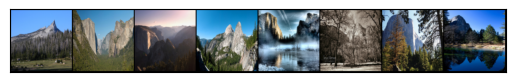

In [39]:
# Set aside some images for evaluation
import random
start_idx = random.randint(0, len(summer_test) - 4 - 1)
summer_images = torch.cat([s.unsqueeze(0) for s in summer_test[start_idx:start_idx + 4]["images"]], dim=0)
winter_images = torch.cat([s.unsqueeze(0) for s in winter_test[start_idx:start_idx + 4]["images"]], dim=0)
summer_labels = summer_test[:4]["labels"]
winter_labels = winter_test[:4]["labels"]
eval_images = torch.cat([summer_images, winter_images], dim=0)
original_eval_labels = torch.Tensor(summer_labels + winter_labels)
show(make_grid(images, normalize=True, value_range=(-1, 1)))
original_eval_labels # 0 = summer 1 = winter

In [40]:
def get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

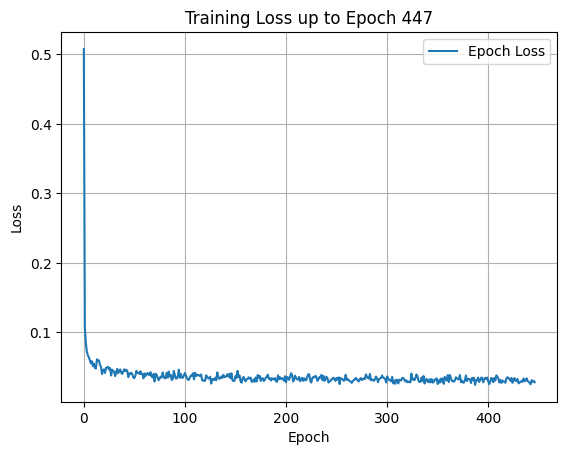

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

Training loop:   0%|          | 0/55 [00:00<?, ?it/s]

KeyboardInterrupt: 

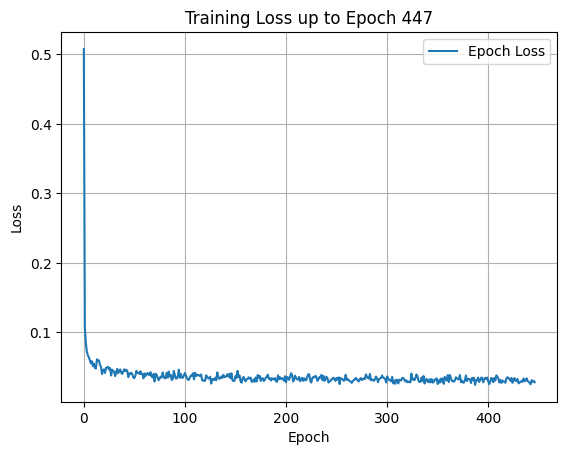

In [12]:
device = "cuda"
num_epochs = 1000
save_every = 10
num_channels = 3
num_classes = 2
num_timesteps = 500
unet = UNet(num_channels, num_classes).to(device)
scheduler = NoiseScheduler(num_timesteps)
ddpm_model = Diffuser(
    unet,
    scheduler,
    num_timesteps=num_timesteps,
    num_classes=num_classes,
    eta=0.3,
)
ddpm_model.to(device)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=1e-3)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

# Create a list to store the average loss of each epoch
epoch_losses = []

fig, ax = plt.subplots()
display_handle = display(fig, display_id=True)

with tqdm(range(num_epochs), desc="Epoch") as ep:
    for epoch in ep:
        ddpm_model.train()  # Setting the model to training mode
    
        pbar = tqdm(train_dataloader, desc="Training loop", leave=False)
        batch_losses = []  # List to store the loss of each batch
        for batch in pbar:
            optimizer.zero_grad()  # Zeroing the gradients
            lr = lr_scheduler.get_last_lr()
            x = batch["images"].to(device)
            class_labels = batch["labels"].to(device)
            # x = batch.to(device)
            loss = ddpm_model(x, class_labels)  # Forward pass to compute the loss
            loss.backward()  # Backward pass to compute gradients
            nn.utils.clip_grad_norm_(ddpm_model.parameters(), 2.0)
            optimizer.step()  # Update model parameters
            lr_scheduler.step()
            # Store the loss of each batch
            batch_losses.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    
        # Calculate and store the average loss of the epoch
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)
        ep.set_postfix(avg_loss=epoch_avg_loss, lr=lr)
        
        # Clear the previous plot and plot the updated epoch_losses
        ax.clear()
        ax.plot(epoch_losses, label="Epoch Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Training Loss up to Epoch {epoch + 1}")
        ax.grid(True)
    
        # Redraw the plot
        display_handle.update(fig)

        if epoch % save_every == 0:
            ddpm_model.eval()
            with torch.no_grad():
                samples, _ = ddpm_model.sample_v3(8, (3, img_size, img_size), device)
                sample_set = torch.cat([samples, x[:8]], dim=0)
                grid = make_grid(
                    sample_set, normalize=True, value_range=(-1, 1), nrow=4
                )
                save_image(grid, f"./samples/ddim_sample_{epoch}.png")

                torch.save(ddpm_model.state_dict(), "./models/ddpm_latest.pth")
    
    plt.close()

In [21]:
x_i = torch.randn(8, 3, 64, 64)
c_i = torch.arange(0, 2)
c_i = c_i.repeat(int(8/c_i.shape[0]))
context_mask = torch.zeros_like(c_i)
c_i = c_i.repeat(2)
context_mask = context_mask.repeat(2)
context_mask[8:] = 1
x_i = x_i.repeat(2,1,1,1)
c_i, context_mask

(tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]))

In [23]:
def guided_sampler(self, x_i, c_i, n_samples, size, device, guidance_scale = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = x_i.to(device)  # x_T ~ N(0, 1), sample initial noise
        context_mask = torch.zeros_like(c_i).to(device)
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_samples:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        for i in tqdm(range(self.num_timesteps, 0, -1), desc="Sampling"):
            t = torch.tensor([i / self.num_timesteps]).to(device)
            t = t.repeat(n_samples,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t = t.repeat(2,1,1,1)

            z = torch.randn(n_samples, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            predicted_noise = self.unet(x_i, c_i, t, context_mask)
            predicted_noise1 = predicted_noise[:n_samples]
            predicted_noise2 = predicted_noise[n_samples:]
            predicted_noise = (1 + guidance_scale) * predicted_noise1 - guidance_scale * predicted_noise2
            x_i = x_i[:n_samples]
            x_i = self.noise_scheduler.denoise(x_i, predicted_noise, z, i)
            
            if i % 20==0 or i == self.num_timesteps or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

def ddim_sampler(model, x, labels, n_samples, size, device, guidance=1.0) -> torch.Tensor:
    x = x.to(device)
    labels = labels.to(device)
    for t in tqdm(range(model.num_timesteps, 1, -1), desc="Sampling images", leave=False):
        z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
        predicted_noise = model.unet(x, torch.tensor(t / model.num_timesteps).to(device).repeat(n_samples, ), class_labels=labels, guidance=guidance)
        x0_t = (x - predicted_noise * (1 - model.noise_scheduler.alpha_hat[t]).sqrt()) / model.noise_scheduler.alpha_hat[t].sqrt()
        c1 = model.eta * ((1 - model.noise_scheduler.alpha_hat[t] / model.noise_scheduler.alpha_hat[t - 1]) * (1 - model.noise_scheduler.alpha_hat[t - 1]) / (
                1 - model.noise_scheduler.alpha_hat[t])).sqrt()
        c2 = ((1 - model.noise_scheduler.alpha_hat[t - 1]) - c1 ** 2).sqrt()
        x = self.noise_scheduler.alpha_hat[t - 1].sqrt() * x0_t + c1 * z + c2 * predicted_noise

    return x, labels

In [57]:
from datasets import concatenate_datasets
ds = load_dataset("../../ddpm/ddpm-data/summer2winter_yosemite/train")
summer = ds.filter(lambda x: x["label"] == 0)["train"].take(100)
winter = ds.filter(lambda x: x["label"] == 1)["train"].take(100)
ds_sub = concatenate_datasets([summer, winter])

Resolving data files:   0%|          | 0/2193 [00:00<?, ?it/s]

In [58]:
summer

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

In [59]:
img_size = 256
preprocess = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [label for label in examples["label"]]
    return {"images": images, "labels": labels}

summer.set_transform(transform)
winter.set_transform(transform)

In [38]:
summer_images = torch.cat([s.unsqueeze(0) for s in summer[:4]["images"]], dim=0)
winter_images = torch.cat([s.unsqueeze(0) for s in winter[:4]["images"]], dim=0)
summer_labels = summer[:4]["labels"]
winter_labels = winter[:4]["labels"]
images = torch.cat([summer_images, winter_images], dim=0).to(device)
original_labels = torch.Tensor(summer_labels + winter_labels).to(device)
show(make_grid(images, normalize=True, value_range=(-1, 1)))
original_labels

NameError: name 'summer' is not defined

In [37]:
1 - labels

tensor([1., 1., 1., 1., 0., 0., 0., 0.])

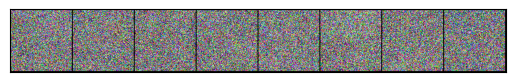

In [89]:
noised_images, _ = ddpm_model.noise_scheduler.noise_images(images, torch.tensor([500]).to(device))
show(make_grid(noised_images, normalize=True, value_range=(-1, 1)))

In [92]:
c_i = torch.tensor([1., 1., 1., 1., 0., 0., 0., 0.]).to(device).reshape(-1,)
samples, _ = guided_sampler(ddpm_model, noised_images, c_i, 8, (3, img_size, img_size), device, 0.0)

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 

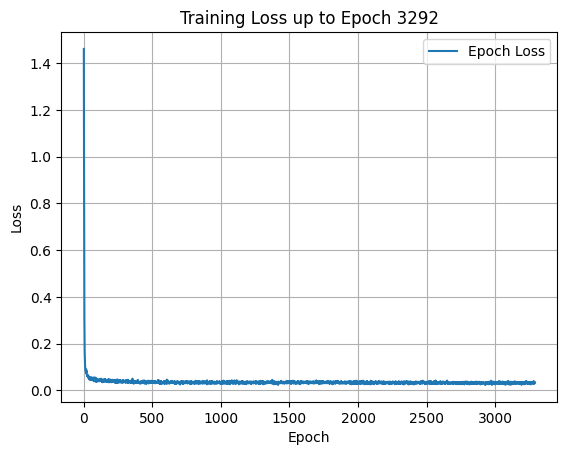

Epoch:   0%|          | 0/2999 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

Training loop:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

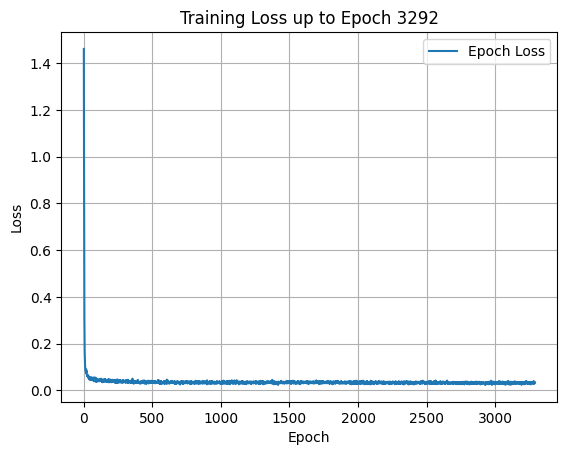

In [13]:
fig, ax = plt.subplots()
display_handle = display(fig, display_id=True)

with tqdm(range(3001, 6000), desc="Epoch") as ep:
    for epoch in ep:
        ddpm_model.train()  # Setting the model to training mode
    
        pbar = tqdm(train_dataloader, desc="Training loop", leave=False)
        batch_losses = []  # List to store the loss of each batch
        for batch in pbar:
            optimizer.zero_grad()  # Zeroing the gradients
            lr = lr_scheduler.get_last_lr()
            x = batch["images"].to(device)
            class_labels = batch["labels"].to(device)
            # x = batch.to(device)
            loss = ddpm_model(x, class_labels)  # Forward pass to compute the loss
            loss.backward()  # Backward pass to compute gradients
            nn.utils.clip_grad_norm_(ddpm_model.parameters(), 2.0)
            optimizer.step()  # Update model parameters
            lr_scheduler.step()
            # Store the loss of each batch
            batch_losses.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    
        # Calculate and store the average loss of the epoch
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)
        ep.set_postfix(avg_loss=epoch_avg_loss, lr=lr)
        
        # Clear the previous plot and plot the updated epoch_losses
        ax.clear()
        ax.plot(epoch_losses, label="Epoch Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Training Loss up to Epoch {epoch + 1}")
        ax.grid(True)
    
        # Redraw the plot
        display_handle.update(fig)

        if epoch % save_every == 0:
            ddpm_model.eval()
            with torch.no_grad():
                if epoch % 1 == 0:
                    samples, _ = ddpm_model.sample_ddim_v2(8, (3, img_size, img_size), device)
                    sample_set = torch.cat([samples, x[:8]], dim=0)
                    grid = make_grid(
                        sample_set, normalize=True, value_range=(-1, 1), nrow=4
                    )
                    save_image(grid, f"./samples/ddim_sample_{epoch}.png")
    
                torch.save(ddpm_model.state_dict(), "./models/ddpm_latest.pth")
    
    plt.close()